In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np


In [2]:
size = 300
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


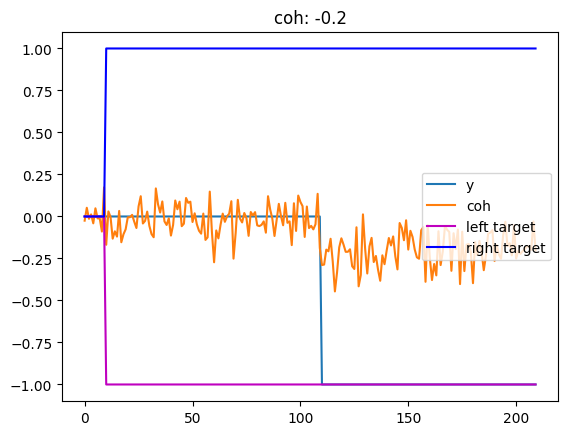

In [4]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




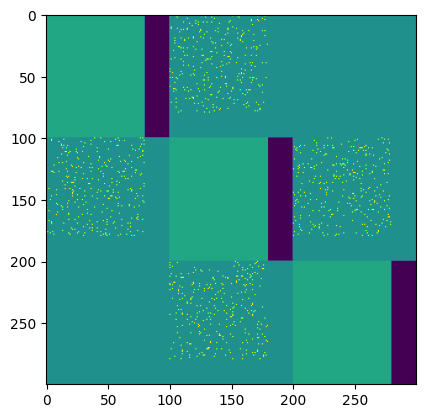

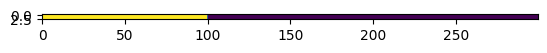

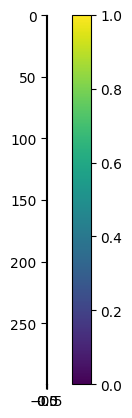

In [5]:
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec

def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec





n_neurons = 300
n_inputs = 3
n_outputs = 1
training_trials = 5000



mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.ones(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)

mask_in[:,100:] = 0
mask_out[:200,:] = 0

mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[:100,100:200] = create_area_conn(20,0.046875,100)
mask_rec[100:200,0:100] = create_area_conn(20,0.046875,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[100:200,200:300] = create_area_conn(20,0.046875,100)
mask_rec[200:300,100:200] = create_area_conn(20,0.046875,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)


# need to transpose mask_rec
plt.imshow(mask_rec)
plt.show()
plt.imshow(mask_in)
plt.show()

plt.imshow(mask_out)
plt.colorbar()
plt.show()


wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()



In [6]:
# net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
#                   wrec_mask= wrec_mask1)
hidden_size = size
temp = torch.normal(0,np.sqrt(1/size),size = (3,hidden_size))
wi_init = (temp*wi_mask)   
temp2 = torch.normal(0,np.sqrt(1/size),size = (hidden_size,1))
wo_init = (temp2*wo_mask)   
temp3 = torch.normal(0,np.sqrt(1/size),size = (hidden_size,hidden_size))
wrec_init = (np.abs(temp3)*wrec_mask)  

b_init = torch.normal(0, np.sqrt(1/size), size = (hidden_size, 1))

hidden_size = size
net = FullRankRNN(3, hidden_size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                  wi_init = wi_init, wo_init = wo_init, wrec_init = wrec_init,
                 b_init = None, add_biases = False)


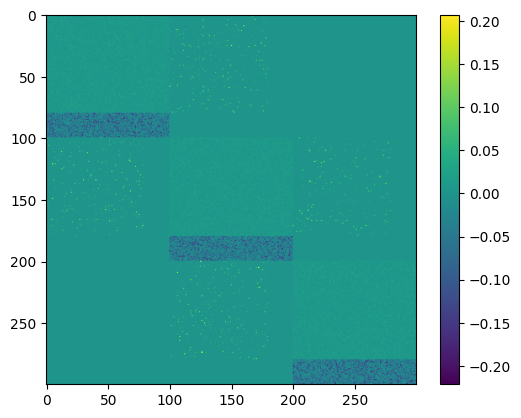

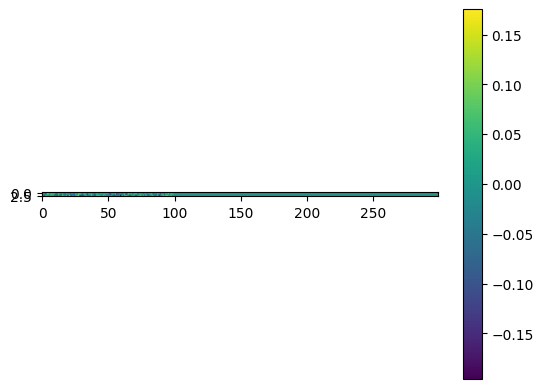

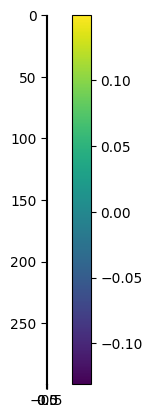

In [7]:
plt.imshow(wrec_init)
plt.colorbar()
plt.show()
plt.imshow(wi_init)
plt.colorbar()
plt.show()
plt.imshow(wo_init)
plt.colorbar()
plt.show()

In [8]:
torch.sum(temp3)

tensor(-4.3494)

In [9]:
torch.sum(wrec_init)

tensor(-0.6121)

# train a full-rank RNN

In [10]:
# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=50, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.2, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the model
# torch.save(net.state_dict(), f'../models/TF{size}.pt')

Training...
initial loss: 1.000
epoch 0:  loss=0.998  (took 19.24 s) *
epoch 1:  loss=0.970  (took 19.09 s) *
epoch 2:  loss=0.884  (took 19.11 s) *
epoch 3:  loss=0.775  (took 19.09 s) *
epoch 4:  loss=0.686  (took 19.06 s) *
epoch 5:  loss=0.622  (took 19.08 s) *
epoch 6:  loss=0.584  (took 19.07 s) *
epoch 7:  loss=0.557  (took 19.04 s) *
epoch 8:  loss=0.538  (took 19.06 s) *
epoch 9:  loss=0.528  (took 19.13 s) *
epoch 10:  loss=0.517  (took 19.11 s) *
epoch 11:  loss=0.509  (took 19.03 s) *
epoch 12:  loss=0.500  (took 19.05 s) *
epoch 13:  loss=0.497  (took 19.07 s) *
epoch 14:  loss=0.491  (took 19.13 s) *
epoch 15:  loss=0.487  (took 19.14 s) *
epoch 16:  loss=0.481  (took 19.09 s) *
epoch 17:  loss=0.480  (took 19.10 s) *
epoch 18:  loss=0.475  (took 19.10 s) *
epoch 19:  loss=0.474  (took 19.10 s) *
loss=0.855, acc=0.627


loss=0.833, acc=0.635


In [11]:
attributes = net.__dict__

In [12]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

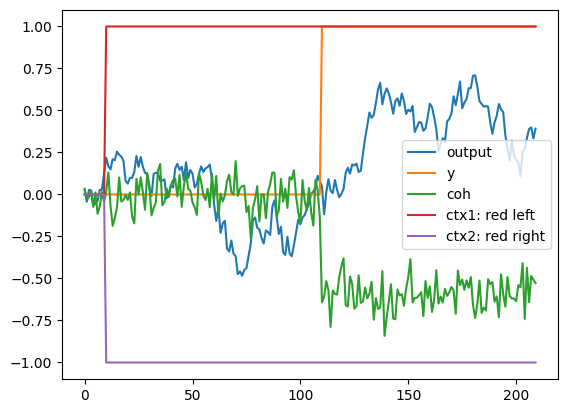

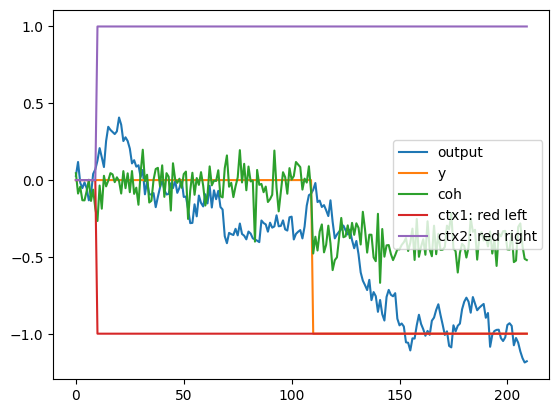

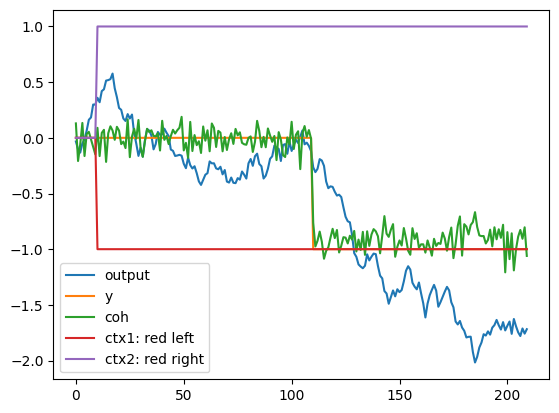

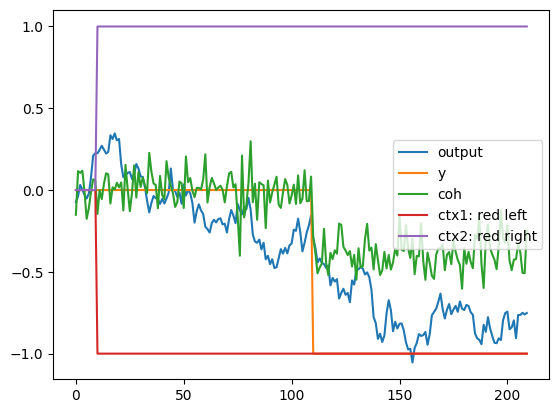

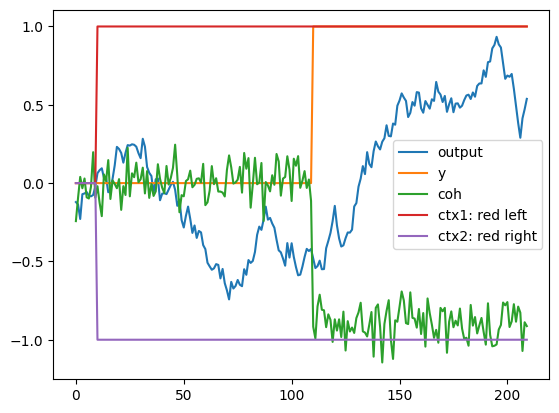

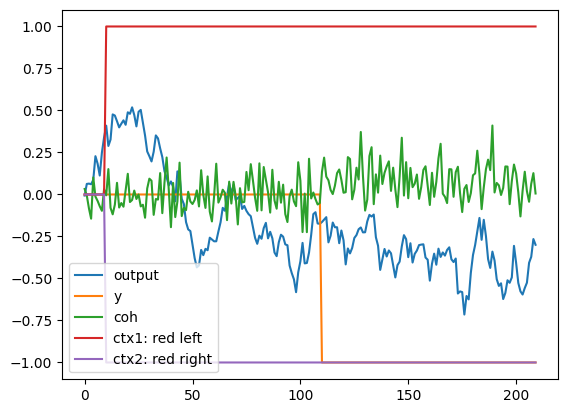

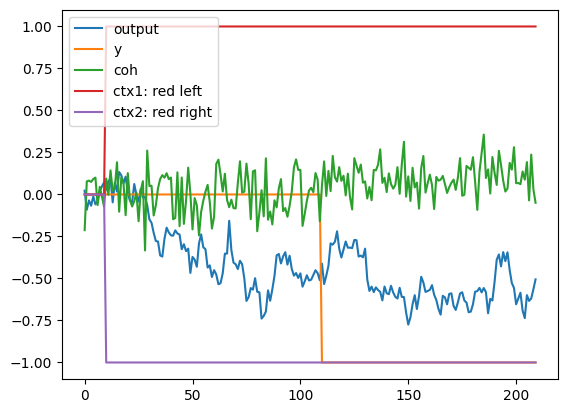

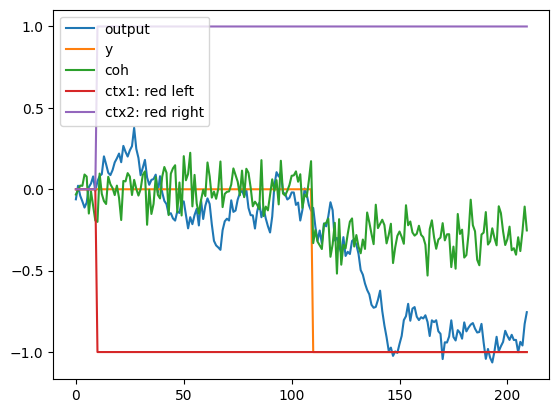

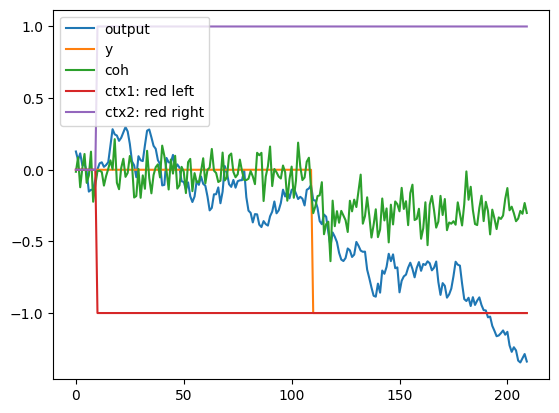

In [13]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [14]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

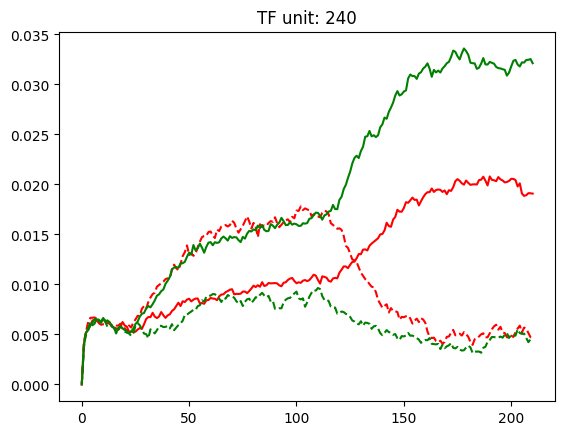

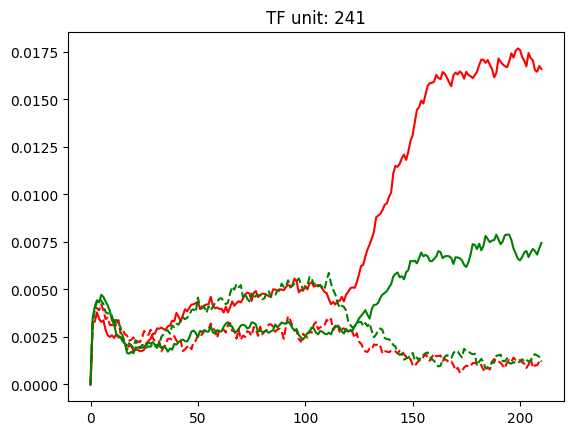

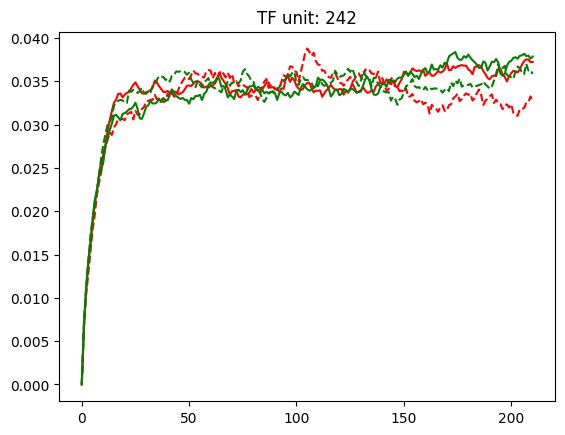

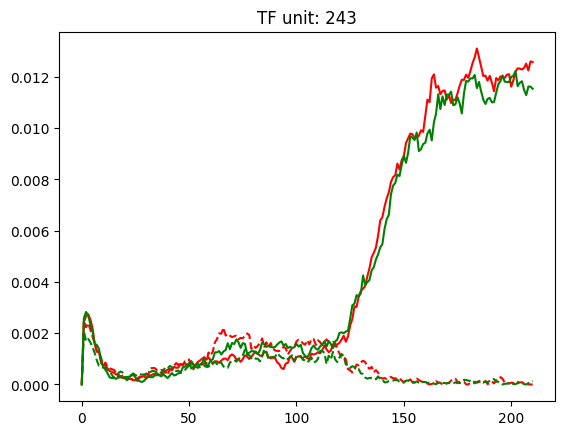

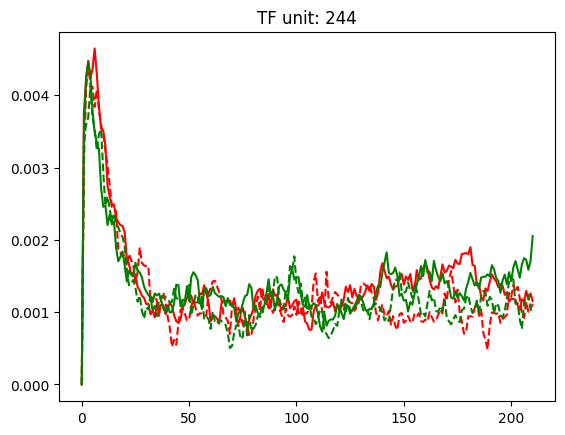

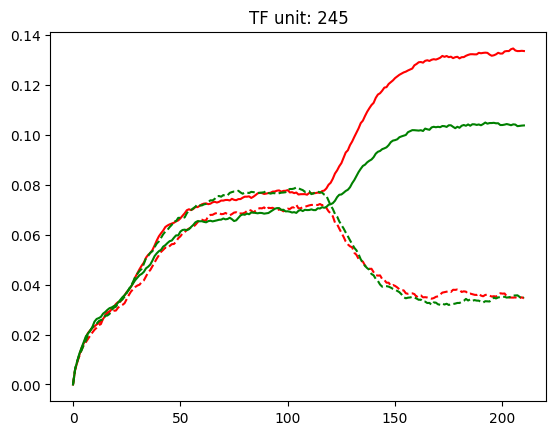

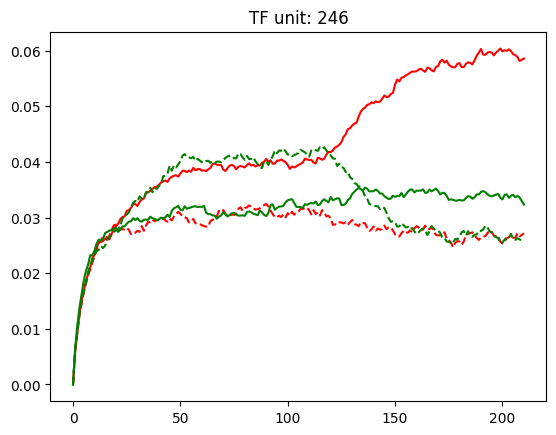

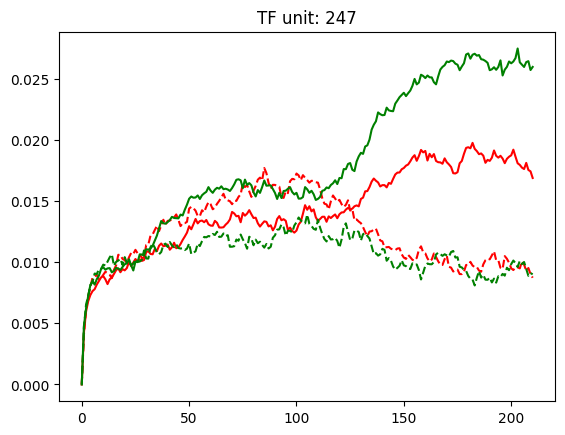

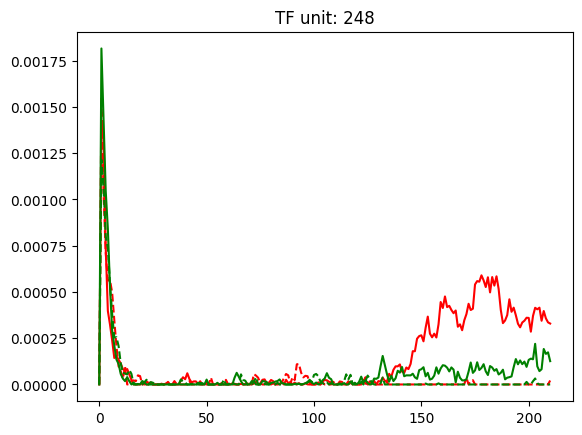

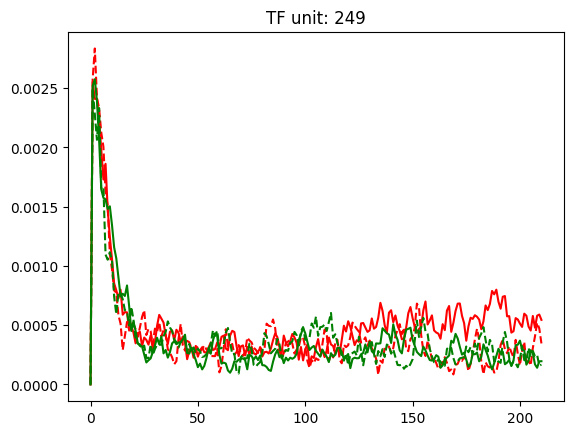

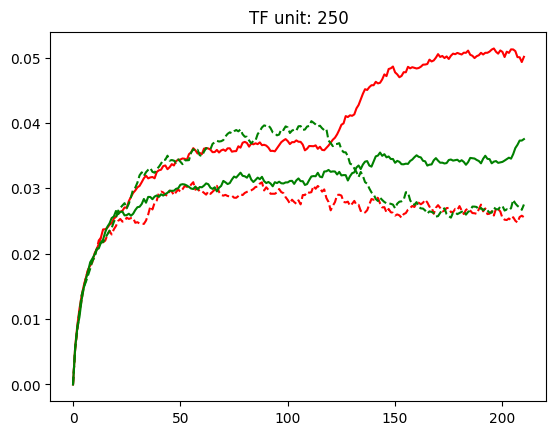

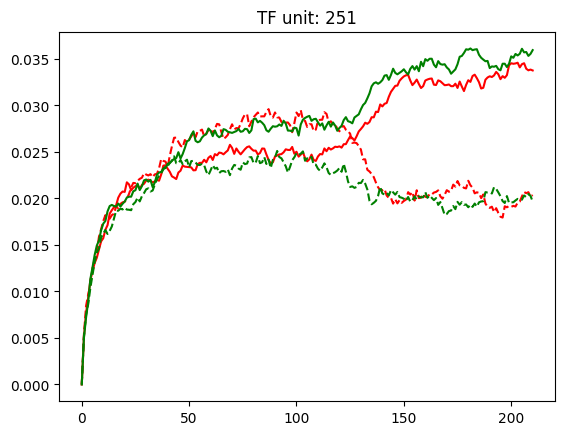

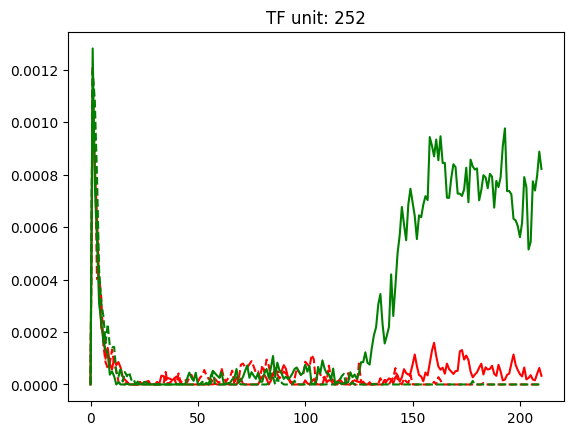

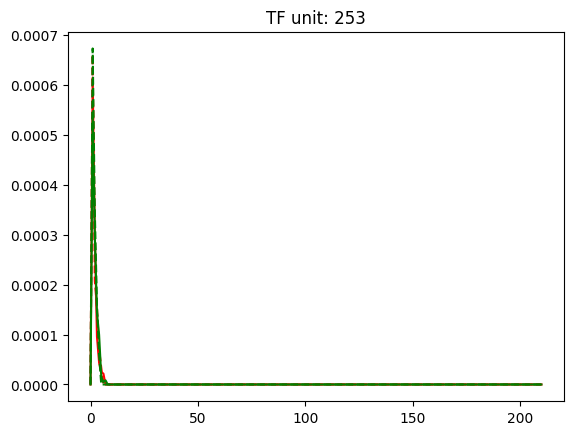

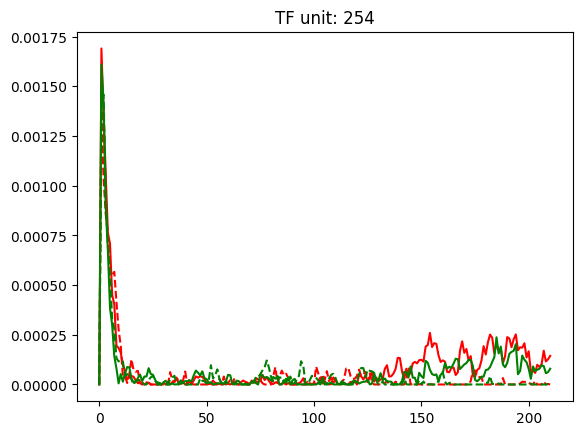

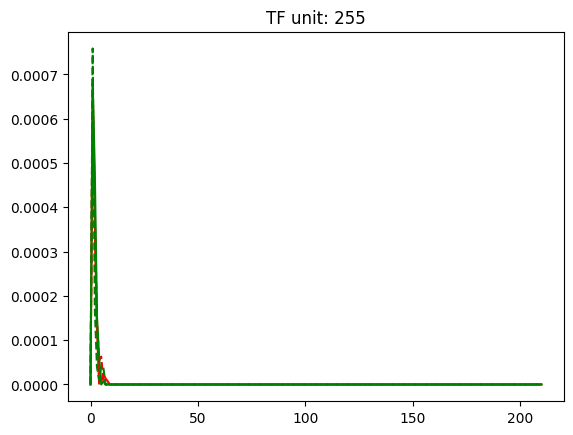

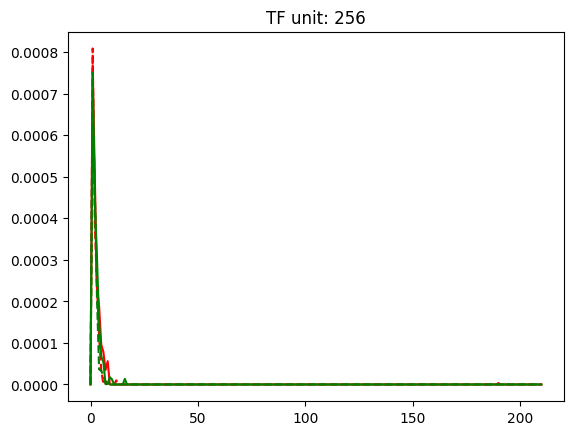

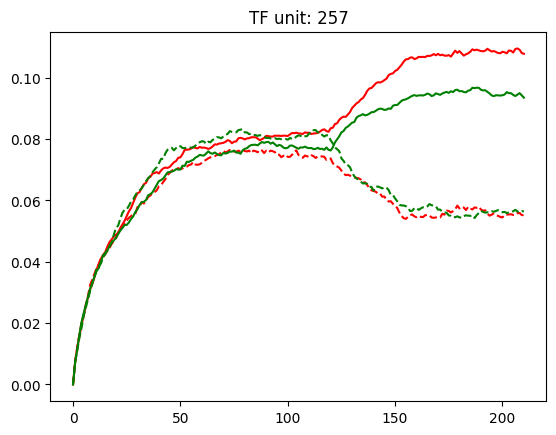

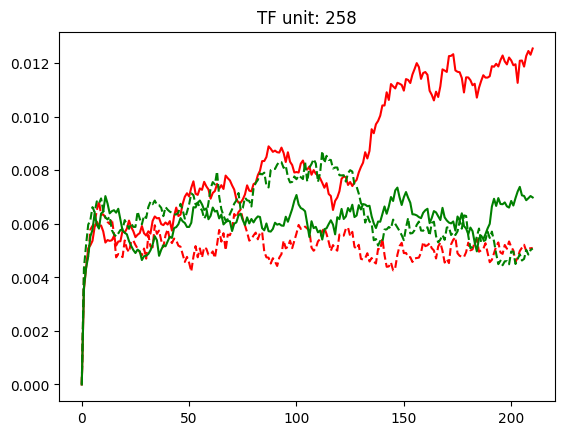

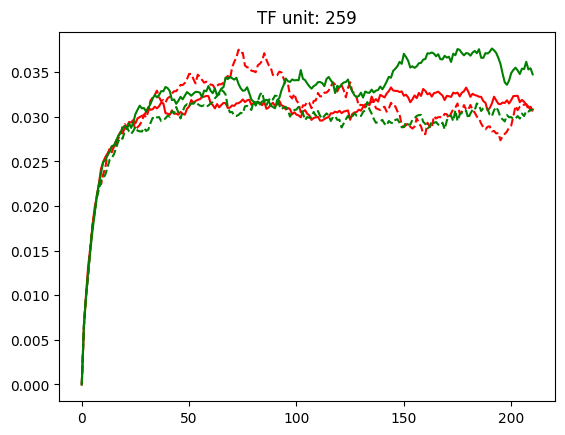

In [18]:
for n in range(240, 260):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


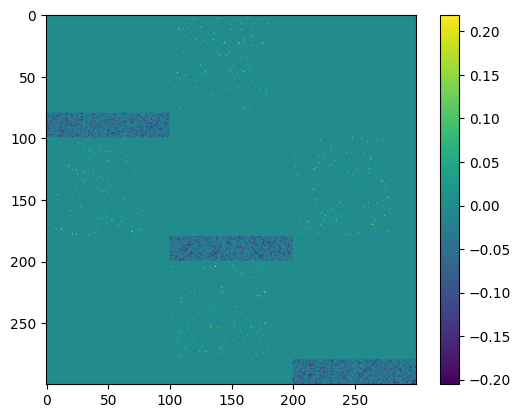

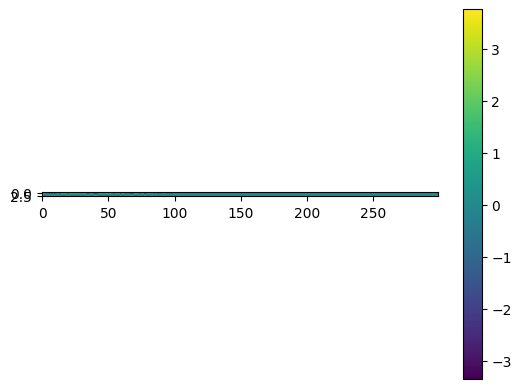

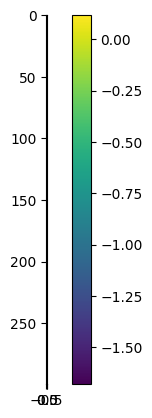

In [19]:
wrec = net.wrec.cpu()
wi = net.wi.cpu()
wo = net.wo.cpu()

a = wrec.detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

b = wi.detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


6.430088

In [25]:
with torch.no_grad():
    net.wi.copy_(net.wi*wi_mask)

    net.wo.copy_(net.wo*wo_mask)
    net.wrec.copy_(np.abs(net.wrec)*wrec_mask)

# save the model
# torch.save(net.state_dict(), f'../models/TFconn{size}.pt')

netwi = net.wi.detach().numpy()
netwo = net.wo.detach().numpy()
netwrec = net.wrec.detach().numpy()

plt.imshow(netwrec)
plt.colorbar()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [18]:
# save the model
# torch.save(net.state_dict(), f'../models/TFnoInputOverlapConn{size}.pt')